# Machine Learning GridSearch Pipeline

In [1]:
# Import libraries
import os
import sys

# cpu_count returns the number of CPUs in the system.
from multiprocessing import cpu_count

import numpy as np
import pandas as pd

# Import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Import preprocessing methods from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# Import PCA
from sklearn.decomposition import PCA

# Import feature_selection tools
from sklearn.feature_selection import VarianceThreshold

# Import models from sklearn
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Import XGBClassifier
from xgboost.sklearn import XGBClassifier

# Import from sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

# Import plotting libraries
import matplotlib.pyplot as plt

# Modify notebook settings
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150
%matplotlib inline
plt.style.use('ggplot')

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Create paths to data file, append `src` directory to sys.path

In [2]:
# Create a variable for the project root directory
proj_root = os.path.join(os.pardir)

# Save path to the processed data file
# "dataset_processed.csv"
processed_data_file = os.path.join(proj_root,
                                   "data",
                                   "processed",
                                   "dataset_processed.csv")

In [3]:
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(proj_root, "src")
sys.path.append(src_dir)

### Read in the processed data

In [4]:
# Read in the processed credit card client default data set.
df = pd.read_csv(processed_data_file, 
                           index_col=0)

df.head()

,y,limit_bal,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,bl_ratio_1,bl_ratio_2,bl_ratio_3,bl_ratio_4,bl_ratio_5,bl_ratio_6,blpl_ratio_1,blpl_ratio_2,blpl_ratio_3,blpl_ratio_4,blpl_ratio_5,blpl_ratio_6,sex_2,edu_2,edu_3,edu_4,marriage_1,marriage_2,marriage_3,pay_1_-2,pay_1_0,pay_1_1,pay_1_2,pay_1_3,pay_1_4,pay_1_5,pay_1_6,pay_1_7,pay_1_8,pay_2_-2,pay_2_0,pay_2_1,pay_2_2,pay_2_3,pay_2_4,pay_2_5,pay_2_6,pay_2_7,pay_2_8,pay_3_-2,pay_3_0,pay_3_1,pay_3_2,pay_3_3,pay_3_4,pay_3_5,pay_3_6,pay_3_7,pay_3_8,pay_4_-2,pay_4_0,pay_4_1,pay_4_2,pay_4_3,pay_4_4,pay_4_5,pay_4_6,pay_4_7,pay_4_8,pay_5_-2,pay_5_0,pay_5_2,pay_5_3,pay_5_4,pay_5_5,pay_5_6,pay_5_7,pay_5_8,pay_6_-2,pay_6_0,pay_6_2,pay_6_3,pay_6_4,pay_6_5,pay_6_6,pay_6_7,pay_6_8
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,0.195650,0.155100,0.034450,0.000000,0.000000,0.000000,0.195650,0.120650,0.034450,0.000000,0.000000,0.000000,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0.022350,0.014375,0.022350,0.027267,0.028792,0.027175,0.022350,0.006042,0.014017,0.018933,0.028792,0.010508,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0.324878,0.155856,0.150656,0.159233,0.166089,0.172767,0.308011,0.139189,0.139544,0.148122,0.154978,0.117211,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0.939800,0.964660,0.985820,0.566280,0.579180,0.590940,0.899800,0.924280,0.961820,0.544280,0.557800,0.570940,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,0,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0.172340,0.113400,0.716700,0.418800,0.382920,0.382620,0.132340,-0.620220,0.516700,0.238800,0.369140,0.369040,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Train test split

In [5]:
# Extract X and y from df
X = df.drop('y', axis=1).values
#y = df[['y']].values
y = df['y'].values

# Train test split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
# Define a function`namestr` to access the name of a variable
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

In [7]:
# Print the shape of X, y, X_train, X_test, y_train, and y_test
for var in [X, y, X_train, X_test, y_train, y_test]:
    print(namestr(var, globals()), 
          'shape:\t',
          var.shape)

X shape:	 (30000, 91)
y shape:	 (30000,)
X_train shape:	 (22500, 91)
X_test shape:	 (7500, 91)
y_train shape:	 (22500,)
y_test shape:	 (7500,)


### Make pipeline

In [8]:
df_X = df.drop('y', axis=1)

In [9]:
def create_binary_feature_list(df=df_X,  
                               return_binary_features=True):
    """
    Docstring ...
    """
    # Create boolean maskDrop the column with the target values
    binary_mask = df.isin([0, 1]).all()
    
    # If return_binary_features=True,
    # create a list of the binary features.
    # If return_binary_features=False,
    # create a list of the nonbinary features.    
    features_list = list(binary_mask[binary_mask == \
                                     return_binary_features].index)

    return features_list

In [10]:
def binary_feature_index_list(df=df_X, 
                              features_list=None):
    """
    Docstring ...
    """
    
    feature_index_list = [df.columns.get_loc(c) for c  \
                          in df.columns if c in features_list]    
    
    return feature_index_list

In [11]:
binary_features = create_binary_feature_list(df=df_X, 
                                             return_binary_features=True)

non_binary_features = create_binary_feature_list(df=df_X,  
                                                 return_binary_features=False)

binary_index_list = \
    binary_feature_index_list(df=df_X, 
                              features_list=binary_features)

non_binary_index_list = \
    binary_feature_index_list(df=df_X, 
                              features_list=non_binary_features)

In [12]:
print('Binary features:\n')
print(''.join('{:2s}: {:40s}'.format(str(i), col) \
              for i, col in zip(binary_index_list,
                                binary_features)))
print('\n')

print('Non-binary features:\n')
print(''.join('{:2s}: {:40s}'.format(str(i), col) \
              for i, col in zip(non_binary_index_list,
                                non_binary_features)))

Binary features:

26: sex_2                                   27: edu_2                                   28: edu_3                                   29: edu_4                                   30: marriage_1                              31: marriage_2                              32: marriage_3                              33: pay_1_-2                                34: pay_1_0                                 35: pay_1_1                                 36: pay_1_2                                 37: pay_1_3                                 38: pay_1_4                                 39: pay_1_5                                 40: pay_1_6                                 41: pay_1_7                                 42: pay_1_8                                 43: pay_2_-2                                44: pay_2_0                                 45: pay_2_1                                 46: pay_2_2                                 47: pay_2_3                                 48: pay_2_4   

#### User defined preprocessors

In [13]:
class NonBinary_PCA(BaseEstimator, TransformerMixin): 
    def __init__(self):
        self.scaler = PCA(n_components=None, random_state=42)

    # Fit PCA only on the non-binary features
    def fit(self, X, y):
        self.scaler.fit(X[:, non_binary_index_list], y)
        return self

    # Transform only the non-binary features with PCA
    def transform(self, X):
        X_non_binary = \
            self.scaler.transform(X[:, non_binary_index_list])

        X_recombined = X_non_binary

        binary_index_list.sort()
        for col in binary_index_list:
            X_recombined = np.insert(X_recombined, 
                                     col,
                                     X[:, col], 
                                     1)
        return X_recombined

In [14]:
class NonBinary_RobustScaler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        self.scaler = RobustScaler()

    # Fit RobustScaler only on the non-binary features
    def fit(self, X, y):
        self.scaler.fit(X[:, non_binary_index_list], y)
        return self

    # Transform only the non-binary features with RobustScaler
    def transform(self, X):
        X_non_binary = \
            self.scaler.transform(X[:, non_binary_index_list])

        X_recombined = X_non_binary

        binary_index_list.sort()
        for col in binary_index_list:
            X_recombined = np.insert(X_recombined, 
                                     col,
                                     X[:, col], 
                                     1)
        return X_recombined

In [15]:
class NonBinary_StandardScaler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        self.scaler = StandardScaler()

    # Fit StandardScaler only on the non-binary features
    def fit(self, X, y):
        self.scaler.fit(X[:, non_binary_index_list], y)
        return self

    # Transform only the non-binary features with StandardScaler
    def transform(self, X):
        X_non_binary = \
            self.scaler.transform(X[:, non_binary_index_list])

        X_recombined = X_non_binary

        binary_index_list.sort()
        for col in binary_index_list:
            X_recombined = np.insert(X_recombined, 
                                     col,
                                     X[:, col], 
                                     1)
        return X_recombined

In [16]:
class NonBinary_MinMaxScaler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        self.scaler = MinMaxScaler()

    # Fit MinMaxScaler only on the non-binary features
    def fit(self, X, y):
        self.scaler.fit(X[:, non_binary_index_list], y)
        return self

    # Transform only the non-binary features with MinMaxScaler
    def transform(self, X):
        X_non_binary = \
            self.scaler.transform(X[:, non_binary_index_list])

        X_recombined = X_non_binary

        binary_index_list.sort()
        for col in binary_index_list:
            X_recombined = np.insert(X_recombined, 
                                     col,
                                     X[:, col], 
                                     1)
        return X_recombined

#### Define the pipeline

In [17]:
# Set a high threshold for removing near-zero variance features
thresh_prob = 0.999
threshold = (thresh_prob * (1 - thresh_prob))

# Create pipeline
pipe = Pipeline([('preprocessing_1', VarianceThreshold(threshold)), 
                 ('preprocessing_2', None), 
                 ('preprocessing_3', None), 
                 ('classifier', DummyClassifier(strategy='most_frequent',
                                                random_state=42))])

# Create parameter grid
param_grid = [
    {'classifier': [LogisticRegression(random_state=42)],
     'preprocessing_1': [None], # [VarianceThreshold(threshold)], 
     'preprocessing_2': [NonBinary_RobustScaler()],
     'preprocessing_3': [None, NonBinary_PCA()],
     'classifier__C': [0.01, 0.1],
     'classifier__penalty': ['l1','l2']},

    
    {'classifier': [XGBClassifier(objective='binary:logistic', n_estimators=1000)], 
     'preprocessing_1': [VarianceThreshold(threshold)], 
     'preprocessing_2': [None],
     'preprocessing_3': [None],
     'classifier__n_estimators': [1000],
     'classifier__learning_rate': [0.01, 0.1],
     'classifier__gamma': [0.01, 0.1],
     'classifier__max_depth': [3, 4],
     'classifier__min_child_weight': [1, 3],
     'classifier__subsample': [0.8],
#     'classifier__colsample_bytree': [0.8, 1.0],
     'classifier__reg_lambda': [0.1, 1.0],
     'classifier__reg_alpha': [0, 0.1]}]


In [18]:
# Set the number of cores to be used
cores_used = cpu_count() - 1
cores_used
cores_used = 1

In [19]:
# Set verbosity
verbosity = 1

# Execute Grid search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc',
                    verbose=verbosity, n_jobs=cores_used)

grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 117.7min finished


Best params:
{'classifier': XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.01, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=1.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8), 'classifier__gamma': 0.01, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 4, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 1000, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 1.0, 'classifier__subsample': 0.8, 'preprocessing_1': VarianceThreshold(threshold=0.000999000000000001), 'preprocessing_2': None, 'preprocessing_3': None}

Best cross-validation score: 0.79


#### Save the grid search object as a pickle file

In [22]:
# Save path to the `models` folder
models_folder = os.path.join(proj_root,
                             "models")

In [21]:
# full_gridsearch_file_name = 'gridsearch_pickle_20171029.pkl'
full_gridsearch_file_name = 'gridsearch_pickle.pkl'

full_gridsearch_path = os.path.join(models_folder,
                                    full_gridsearch_file_name)

joblib.dump(grid, full_gridsearch_path)

['../models/gridsearch_pickle.pkl']

In [22]:
# best_pipeline_file_name = 'pipeline_pickle_20171029.pkl'
best_pipeline_file_name = 'pipeline_pickle.pkl'

best_pipeline_path = os.path.join(models_folder, 
                                  best_pipeline_file_name)

joblib.dump(grid.best_estimator_, best_pipeline_path)

['../models/pipeline_pickle.pkl']

#### Read in the best pipeline

In [30]:
# best_pipeline_file_name = 'pipeline_pickle_20171029.pkl'
best_pipeline_file_name = 'pipeline_pickle.pkl'

best_pipeline_path = os.path.join(models_folder, 
                                  best_pipeline_file_name)

In [31]:
clf = joblib.load(best_pipeline_path) 

#### Check AUC scores

In [32]:
cross_val_results = cross_val_score(clf, 
                                    X_train,
                                    y_train,
                                    scoring="roc_auc", 
                                    cv=5, 
                                    n_jobs=1)

In [33]:
results_mean = np.mean(cross_val_results)

print("Mean Cross validation AUC:\n{}\n".format(results_mean))

Mean Cross validation AUC:
0.7875056854764413



In [34]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessing_1', VarianceThreshold(threshold=0.000999000000000001)), ('preprocessing_2', None), ('preprocessing_3', None), ('classifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.01, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=nan, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=1.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8))])

In [35]:
auc_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])

print("Train AUC:\n{}\n".format(auc_train))

Train AUC:
0.8296736219553531



In [36]:
auc_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

print("Test AUC:\n{}\n".format(auc_test))

Test AUC:
0.779934342685386



In [37]:
dummy_clf = DummyClassifier(strategy='most_frequent',
                                    random_state=42)

In [38]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=42, strategy='most_frequent')

In [39]:
dummy_auc_train = roc_auc_score(y_train, 
                                dummy_clf.predict_proba(X_train)[:,1])

print("Dummy Train AUC:\n{}\n".format(dummy_auc_train))

Dummy Train AUC:
0.5



In [40]:
dummy_auc_test = roc_auc_score(y_test, 
                                dummy_clf.predict_proba(X_test)[:,1])

print("Dummy Test AUC:\n{}\n".format(dummy_auc_test))

Dummy Train AUC:
0.5



#### Plot the Receiver Operating Characteristic Curves

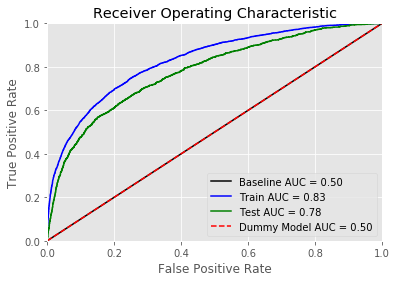

In [41]:
plt.plot([0, 1], [0, 1],'k',  label = 'Baseline AUC = 0.50' )

probs = clf.predict_proba(X_train)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_train, preds)
#roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_train, preds)
plt.plot(fpr, tpr, 'b', label = 'Train AUC = %0.2f' % roc_auc)

probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
#roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_test, preds)
plt.plot(fpr, tpr, 'g', label = 'Test AUC = %0.2f' % roc_auc)

probs = dummy_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
#roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_test, preds)
plt.plot(fpr, tpr, 'r--', label = 'Dummy Model AUC = %0.2f' % roc_auc)

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_curve.png', dpi = 300)

#### Check accuracy scores

In [42]:
cross_val_accuracy = cross_val_score(clf, 
                                    X_train,
                                    y_train,
                                    scoring="accuracy", 
                                    cv=5, 
                                    n_jobs=1, 
                                    verbose=1)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished


In [43]:
accuracy_mean = np.mean(cross_val_accuracy)

print("Mean Cross validation accuracy:\n{:.3f}\n".format(accuracy_mean))

Mean Cross validation accuracy:
0.8203109890150833



In [44]:
dummy_cross_val_accuracy = cross_val_score(dummy_clf, 
                                          X_train,
                                          y_train,
                                          scoring="accuracy", 
                                          cv=5, 
                                          n_jobs=1)

In [45]:
dummy_accuracy_mean = np.mean(dummy_cross_val_accuracy)

print("Baseline accuracy:\n{:.3f}\n".format(dummy_accuracy_mean))

Baseline accuracy:
0.7773777832581621



In [197]:
accuracy_train = accuracy_score(y_train, 
                               clf.predict(X_train))

print("Train Accuracy:\n{:.3f}\n".format(accuracy_train))

print("Train Error Rate:\n{:.3f}\n".format(1 - accuracy_train))

Train Accuracy:
0.833

Train Error Rate:
0.167



In [198]:
accuracy_test = accuracy_score(y_test, 
                               clf.predict(X_test))

print("Test Accuracy:\n{:.3f}\n".format(accuracy_test))

print("Test Error Rate:\n{:.3f}\n".format(1 - accuracy_test))



Test Accuracy:
0.821

Test Error Rate:
0.179



### Save the trained model object as a pickle file

In [46]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessing_1', VarianceThreshold(threshold=0.000999000000000001)), ('preprocessing_2', None), ('preprocessing_3', None), ('classifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.01, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=nan, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=1.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8))])

In [47]:
# trained_model = 'trained_model_20171029.pkl'
trained_model = 'trained_model.pkl'

trained_model_path = os.path.join(models_folder,
                                  trained_model)

joblib.dump(clf, trained_model_path)

['../models/trained_model.pkl']

# Load trained model

In [48]:

# Save path to the `models` folder
models_folder = os.path.join(proj_root,
                             "models")

trained_model = 'trained_model.pkl'

trained_model_path = os.path.join(models_folder,
                                  trained_model)

clf = joblib.load(trained_model_path) 

In [49]:
clf

Pipeline(memory=None,
     steps=[('preprocessing_1', VarianceThreshold(threshold=0.000999000000000001)), ('preprocessing_2', None), ('preprocessing_3', None), ('classifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.01, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=nan, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=1.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8))])

# LIFT

In [181]:
def true_positives(t, X, y, clf):
    """
    t is a classification threshold, where 0 <= t <= 1
    
    
    """
    true_actual = (y == 1)
    
    predicted_true = clf.predict_proba(X)[:,1] > t
    
    tp = true_actual * predicted_true
    
    return np.sum(tp)

def false_positives(t, X, y, clf):
    """
    t is a classification threshold, where 0 <= t <= 1
    
    
    """
    false_actual = (y != 1)
    
    predicted_true = clf.predict_proba(X)[:,1] > t
    
    fp = false_actual * predicted_true
    
    return np.sum(fp)

def tp_plus_fp(t, X, y, clf):
    """
    t is a classification threshold, where 0 <= t <= 1
    
    
    """
    tp = true_positives(t, X, y, clf)
    fp = false_positives(t, X, y, clf)
    
    return tp + fp


In [182]:
ts = list(np.arange(0.0, 1.01, 0.01))

tps = [true_positives(t, X_train, y_train, clf) for t in ts]

tpfp = [tp_plus_fp(t, X_train, y_train, clf) for t in ts]

tps = np.array(tps)
tpfp = np.array(tpfp)

In [183]:
# Theoretically best curve
tp_best = np.clip(tpfp, 0, np.max(tps))

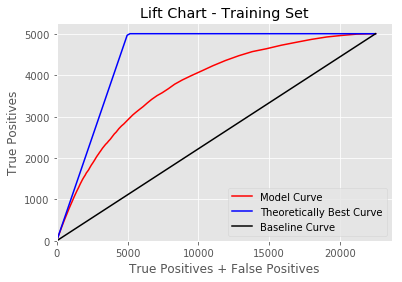

In [184]:
plt.plot(tpfp, 
         tps, 
         'r', 
         label = 'Model Curve')

plt.plot(tpfp, 
         tp_best, 
         'b', 
         label = 'Theoretically Best Curve')

plt.plot([0, np.max(tpfp)], 
         [0, np.max(tps)],
         'k',  
         label = 'Baseline Curve' )

plt.title('Lift Chart - Training Set')
plt.legend(loc = 'lower right')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.ylabel('True Positives')
plt.xlabel('True Positives + False Positives')
plt.savefig('lift_chart_train.png', dpi = 300)

# Area ratio

In [185]:
area_best = np.abs(np.trapz(tp_best, tpfp))

#print("{:,.0f}".format(area_best))

In [186]:
area_model = np.abs(np.trapz(tps, tpfp))

#print("{:,.0f}".format(area_model))

In [187]:
area_baseline = np.max(tpfp) * np.max(tps) / 2

#print("{:,.0f}".format(area_baseline))

In [188]:
area_ratio = (area_model - area_baseline) / \
                (area_best - area_baseline) 

print("Area ratio:\t",
      "{:.3f}".format(area_ratio))

Area ratio:	 0.659


# Test

Area ratio:	 0.560


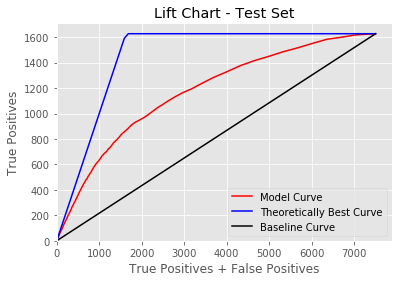

In [189]:
ts = list(np.arange(0.0, 1.01, 0.01))

tps = [true_positives(t, X_test, y_test, clf) for t in ts]

tpfp = [tp_plus_fp(t, X_test, y_test, clf) for t in ts]

tps = np.array(tps)
tpfp = np.array(tpfp)

# Theoretically best curve
tp_best = np.clip(tpfp, 0, np.max(tps))

plt.plot(tpfp, 
         tps, 
         'r', 
         label = 'Model Curve')

plt.plot(tpfp, 
         tp_best, 
         'b', 
         label = 'Theoretically Best Curve')

plt.plot([0, np.max(tpfp)], 
         [0, np.max(tps)],
         'k',  
         label = 'Baseline Curve' )

plt.title('Lift Chart - Test Set')
plt.legend(loc = 'lower right')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.ylabel('True Positives')
plt.xlabel('True Positives + False Positives')
plt.savefig('lift_chart_test.png', dpi = 300)


area_best = np.abs(np.trapz(tp_best, tpfp))
area_model = np.abs(np.trapz(tps, tpfp))
area_baseline = np.max(tpfp) * np.max(tps) / 2
area_ratio = (area_model - area_baseline) / \
                (area_best - area_baseline) 

print("Area ratio:\t",
      "{:.3f}".format(area_ratio))
